# A Deep Learning Program Run on Commercial Pelagic Vessels in the Pacific

## Introduction

With the advent of modern technologies, we have seen unprecedented growth, yet this growth is proving to be problematic. An area that hs been heavily impacted by these modern technologies is our oceans. This project seeks to create a solution to an issue facing commercial pelagic longliners in the Pacific Ocean. An industrial longliner can set over 500 miles (800 km) worth of line with over ten thouasands hooks. With so many hooks, longliners have trouble keeping track of catches, and this is where this deep learning project seeks to help. By using deep learning image labelling, this project aims to be able to identify fish species in an image. The data set was retrieved from https://www.fishnet.ai/download from the v0.2.0 Dataset (September 2020) and has 12 GB of images containing different fish and animal species from commerical longliners operating in the Pacific.  The goal of this project is to able to accurately return the species present in an image and be able to predict the species in an image. 

**Packages Used**

In [1]:
import shutil 
import keras
from tensorflow.keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import *
from keras.preprocessing import image
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping # early stopping
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
np.random.seed(34)

## Data Preprocessing

The original CSV ("*foid_labels_bbox_v020.csv*") contains 9 categories the image name, the bounding box, its corresponding dimensions, and the corresponding labels with the bounding boxes. For the purpose of multilabeling images, in this project only *label_l2* and image name is utilized.  The categoris in *label_l2* are 
> ['HUMAN', 'NoF', 'YFT', 'ALB', 'OTH', 'BILL', 'DOL', 'BET', 'SKJ', 'LAG', 'SHARK', 'OIL', 'PLS', 'TUNA', 'WATER']

each label represents either kind of fish or an obstruction on the camera. 


Due to RAM complications, this project takes a randomly selected group of 10,000 images, which were saved into a CSV file ("*Subsetted_Fish.csv*"). The fish data frame takes the image id and 15 categories based on *label_l2*. Each column in the fish data frame is a *label_l2* category, and if the image contains one of those categories it has a 0 in the respective column else it has a zero (binary encoding of contains? Y/N).

## Solution

First *Subsetted_Fish.csv* is read in (in this case called *file_name.csv*). And assign it to the pandas dataframe named subsetted. 

In [2]:
subsetted= pd.read_csv("../input/subsetted/file_name.csv")


Next in order to assign the corresponding images found in the "subsetted" dataframe a new folder called 'image' is created using the 
**os** package. 

In [3]:
os.makedirs('image')

In order for "subsetted" to be used properly it needs to be cleaned. First, the null values must be filled with 0 for the absence of that category in the image. Next, the redundant row "Unnamed" is dropped. The new "subsetted" data frame is called proper as it is properly formatted.

In [4]:
proper = subsetted.fillna(0)
proper = proper.drop(columns="Unnamed: 0")
proper.head()

,img_id,HUMAN,NoF,YFT,ALB,OTH,BILL,DOL,BET,SKJ,LAG,SHARK,OIL,PLS,TUNA,WATER
0,dabf988c-db28-11ea-b646-f751770c2667,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,da4cbfa6-db28-11ea-b466-bb5f9e1c58d1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,94d2518e-23f0-11e9-a8ae-97372c179db9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,da97f94e-db28-11ea-a4e2-6bc6f4fb7b0e,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dad1c426-db28-11ea-bb6b-3f63cdd14d9d,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Since humans are present in every single image it does not make sense to include this category. 

In [5]:
# Testing w/o Humans
proper = proper.drop(columns="HUMAN")
proper.head()

,img_id,NoF,YFT,ALB,OTH,BILL,DOL,BET,SKJ,LAG,SHARK,OIL,PLS,TUNA,WATER
0,dabf988c-db28-11ea-b646-f751770c2667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,da4cbfa6-db28-11ea-b466-bb5f9e1c58d1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,94d2518e-23f0-11e9-a8ae-97372c179db9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,da97f94e-db28-11ea-a4e2-6bc6f4fb7b0e,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dad1c426-db28-11ea-bb6b-3f63cdd14d9d,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The image names then are put into a list called *list_ids*, so we can move the images in "proper" to the image folder.

In [6]:
list_ids= list(proper['img_id'])
list_ids[3]

'da97f94e-db28-11ea-a4e2-6bc6f4fb7b0e'

Using the image ids from *list_ids*, the image id is then concatenated with where the file is stored ( a Kaggle data set). Then if the image does not exist then there is a failure and the function exits. If the file path does exists the image is copied then moved into the image folder using the **shutil** package.

In [7]:
for i in tqdm(list_ids):
    c = i+'.jpg'
    get_image = '/kaggle/input/attempt-13/foid_images_v020/images/' + c
    if not os.path.exists('/kaggle/input/attempt-13/foid_images_v020/images/'+c):
            print("FAILED")
            break
    else:
        move_image = shutil.copy(get_image,'/kaggle/working/image/')

100%|██████████| 10000/10000 [00:54<00:00, 183.96it/s]


Due to RAM limits, "proper" is further subsetted to 1000 images. The new data frame is called "proper_sub".

In [8]:
proper_sub= proper.head(1000)


Printing out the first 5 elements of the data frame "proper_sub".

In [9]:
proper_sub.head()

,img_id,NoF,YFT,ALB,OTH,BILL,DOL,BET,SKJ,LAG,SHARK,OIL,PLS,TUNA,WATER
0,dabf988c-db28-11ea-b646-f751770c2667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,da4cbfa6-db28-11ea-b466-bb5f9e1c58d1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,94d2518e-23f0-11e9-a8ae-97372c179db9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,da97f94e-db28-11ea-a4e2-6bc6f4fb7b0e,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dad1c426-db28-11ea-bb6b-3f63cdd14d9d,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We are creating the image array called **X**. First all the rows are taken in to account, row by row the for loop resizes the images in to a (400, 400, 3) shape. The images are then converted to an array and rescaled by 255. The rescaled images are saved to **numpy** array called **X**.

In [10]:
train_image = []
for i in tqdm(range(proper_sub.shape[0])):
    img = image.load_img('./image/'+proper['img_id'][i]+'.jpg',target_size=(400,400,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 1000/1000 [00:18<00:00, 53.52it/s]


The dimensions of **X** are *1000x400x400x3*.

In [11]:
X.shape

(1000, 400, 400, 3)

To check if **X** worked properly, using matplotlib, the second array value is converted back into an image.

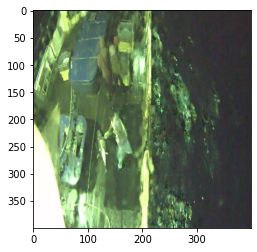

In [12]:
plt.imshow(X[2])

Next the **Y** array is created from the *proper_sub*, for proper cleaning the 'img_id' column must be dropped.

In [13]:
y = np.array(proper_sub.drop(['img_id'],axis=1))
y.shape

(1000, 14)

Using the **sklearn** package we take the train_test_split function inputting the **X** and **y** **numpy** arrays. The arrays are then split into X_train, X_test, y_train, and y_test.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

# 

### Actually Creating the Model

After much trial and tribulation, the decision was made to use transfer learning rather than a model from scratch.

Utilizing the **MobileNetV2**, the model takes in the image of size (400, 400, 3) then uses the weights associated with the imagenet database. We also utilize a 2D pooling. The model ouput layer has 14 neurons (one for each category), and uses *sigmoid* to normalize the values.

In [15]:
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
#model2 = Sequential()
#model2.add()

base_model = MobileNetV2(input_shape = (400, 400, 3), include_top = False, weights = "imagenet")
x = base_model.output
x = GlobalAveragePooling2D()(x)
# ADD A DENSE LAYER WITH 1024 neurons
x = Dense(1024, activation='relu', kernel_initializer=HeNormal())(x)
# ADD AN OUTPUT LAYER FOR BINARY CLASSIFICATION
#predictions = Dense(15, activation='sigmoid')(x)
## Test w/o Humans
predictions = Dense(14, activation='sigmoid')(x)
## returns 13% accuracy
model2 = Model(inputs=base_model.input, outputs=predictions)


2022-05-15 18:47:15.293028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 18:47:15.420534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 18:47:15.422023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 18:47:15.424781: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

9420800/9406464 [==============================] - 0s 0us/step


We output the model summary of the model, which **MobileNetV2** slightly modified.

In [16]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 200, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 200, 200, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 200, 200, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

# Compiling and fitting the Model

We use the **SGD** optimizer with a learning rate of 0.0001, and use the loss function for 'binary_crossentropy' because if each category occurs it is either a zero or one.

In [17]:
from tensorflow.keras.optimizers import SGD
model2.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), metrics=['accuracy'], 
              loss='binary_crossentropy')

We run the model on 20 epochs for fear of over fitting. We do not use the early stopping function because the data set is so sparse that overfitting is extremely likely to occure because the prediction of all zeros has a high accuracy.

In [18]:

fitted_model= model2.fit(X_train, y_train, batch_size=64, 
                            epochs=20, validation_split=0.2)


2022-05-15 18:47:25.527122: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1382400000 exceeds 10% of free system memory.
2022-05-15 18:47:27.062254: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1382400000 exceeds 10% of free system memory.
2022-05-15 18:47:28.294293: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-05-15 18:47:33.180602: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122880000 exceeds 10% of free system memory.
2022-05-15 18:47:33.181511: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122880000 exceeds 10% of free system memory.
2022-05-15 18:47:33.359622: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122880000 exceeds 10% of free system memory.
2022-05-15 18:47:34.347197: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


12/12 [==============================] - 28s 1s/step - loss: 0.8483 - accuracy: 0.0097 - val_loss: 0.9236 - val_accuracy: 0.0500
Epoch 2/20
12/12 [==============================] - 12s 1s/step - loss: 0.8055 - accuracy: 0.0097 - val_loss: 0.8726 - val_accuracy: 0.0500
Epoch 3/20
12/12 [==============================] - 12s 998ms/step - loss: 0.7507 - accuracy: 0.0097 - val_loss: 0.8196 - val_accuracy: 0.0500
Epoch 4/20
12/12 [==============================] - 12s 994ms/step - loss: 0.6977 - accuracy: 0.0125 - val_loss: 0.7698 - val_accuracy: 0.0556
Epoch 5/20
12/12 [==============================] - 12s 983ms/step - loss: 0.6498 - accuracy: 0.0097 - val_loss: 0.7242 - val_accuracy: 0.0611
Epoch 6/20
12/12 [==============================] - 12s 1s/step - loss: 0.6081 - accuracy: 0.0208 - val_loss: 0.6829 - val_accuracy: 0.0667
Epoch 7/20
12/12 [==============================] - 12s 1s/step - loss: 0.5695 - accuracy: 0.0222 - val_loss: 0.6457 - val_accuracy: 0.0722
Epoch 8/20
12/12 [====

# Evaluating the Model


The function is very inaccurate. The function does give concrete results, but it has large issues with overfitting. The overfitting of this model quickly becomes quite extreme, so underfitting is the preferred option. The graph below shows the increase in accuracy as the epochs increase and the decrease of loss which is good.

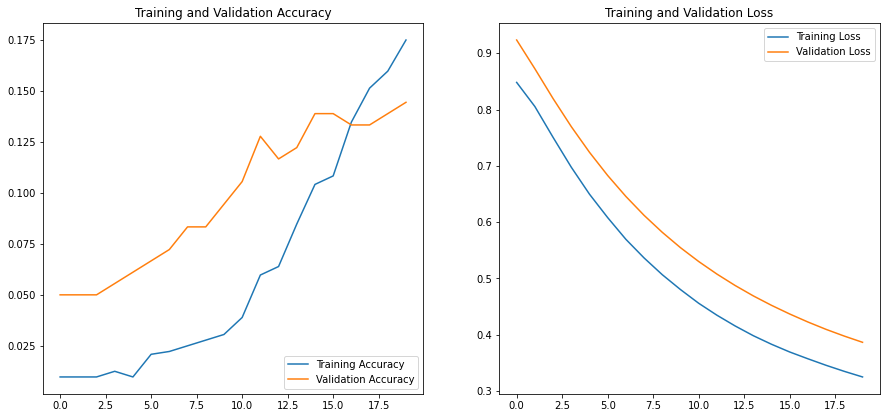

In [19]:
acc = fitted_model.history['accuracy']
val_acc = fitted_model.history['val_accuracy']
loss = fitted_model.history['loss']
val_loss = fitted_model.history['val_loss']
epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model prediction accuracy is around 20%, which should be improved.

In [20]:
print(model2.evaluate(X_test, y_test))

4/4 [==============================] - 1s 104ms/step - loss: 0.4003 - accuracy: 0.1200
[0.4003220498561859, 0.11999999731779099]


Here the model is checked that it hasn't picked up patterns in the sparsity, but is rather making predictions based on the image.

In [21]:
preds2 = model2.predict(X_test[:10])

In the first 10 predictions, the model's inaccuracy is apparent, as it predicts only 3/10 rows.

In [22]:
np.round(preds2)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [23]:
y_test[:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In order to see how the model fares in reality against the different categories, a multilabel confusion matrix is created. The multilabel confusion matrix compares the predicted values against the tested value and finds that the model is highly inaccurate in the categories that are present (which are few due to the sparsity).

In [24]:
from sklearn.metrics import multilabel_confusion_matrix
preds = model2.predict(X_test) 
y_pred = np.round(preds)
multilabel_confusion_matrix(y_test, y_pred)

array([[[ 93,   2],
        [  5,   0]],

       [[ 76,   3],
        [ 21,   0]],

       [[ 69,   2],
        [ 28,   1]],

       [[ 94,   0],
        [  6,   0]],

       [[ 92,   0],
        [  8,   0]],

       [[ 95,   0],
        [  5,   0]],

       [[ 96,   0],
        [  4,   0]],

       [[ 90,   1],
        [  9,   0]],

       [[ 95,   1],
        [  4,   0]],

       [[100,   0],
        [  0,   0]],

       [[100,   0],
        [  0,   0]],

       [[100,   0],
        [  0,   0]],

       [[ 96,   2],
        [  2,   0]],

       [[100,   0],
        [  0,   0]]])

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Class:" + class_label)

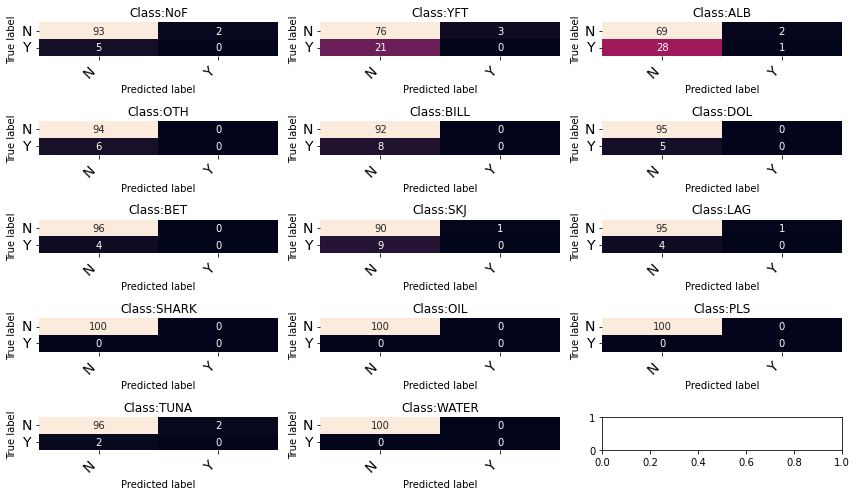

In [26]:
vis_arr = np.asarray(multilabel_confusion_matrix(y_test, y_pred))
labels = ['NoF', 'YFT', 'ALB', 'OTH', 'BILL', 'DOL', 'BET', 'SKJ', 'LAG', 'SHARK', 'OIL', 'PLS', 'TUNA', 'WATER']
fig, ax = plt.subplots(5, 3, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
fig.tight_layout()
plt.show()

In order to create see the true distribution of the test, a frequancy plot is created to display the occurences.

In [27]:
Y_train= pd.DataFrame(y_train)
Y_test= pd.DataFrame(y_test)
preds2 = np.round(model2.predict(X_test))
Y_preds= pd.DataFrame(preds2)
Y_train.columns
(Y_train.groupby(0).size())



0
0.0    882
1.0     18
dtype: int64

In [28]:
y_labels = ['NoF', 'YFT', 'ALB', 'OTH', 'BILL', 'DOL', 'BET', 'SKJ', 'LAG', 'SHARK', 'OIL', 'PLS', 'TUNA', 'WATER']
print(len(y_labels))
counts = []
for i in range(0,14):
    x = list(Y_train.groupby(i).size())
    counts.append(x[0]/1000)
print(counts)
print(len(counts))
frequency= [round(1-i, 3) for i in counts]
print(frequency)
print(len(frequency))

14
[0.882, 0.689, 0.614, 0.839, 0.866, 0.863, 0.837, 0.832, 0.884, 0.891, 0.9, 0.899, 0.898, 0.897]
14
[0.118, 0.311, 0.386, 0.161, 0.134, 0.137, 0.163, 0.168, 0.116, 0.109, 0.1, 0.101, 0.102, 0.103]
14


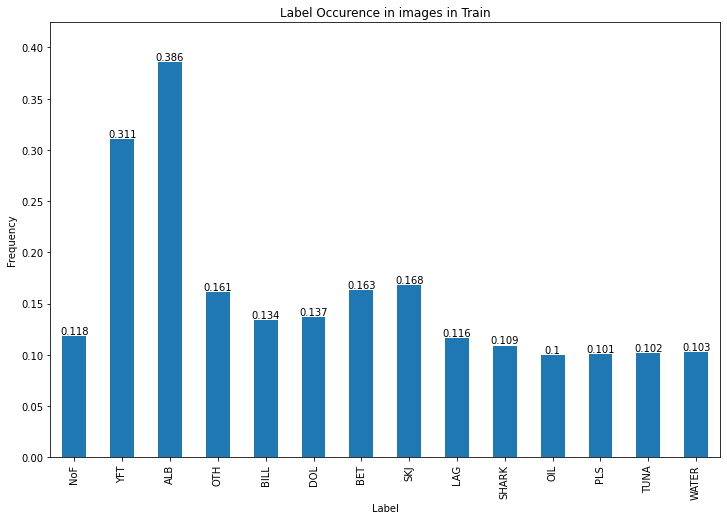

In [29]:
df_counts = pd.DataFrame({'Frequency': frequency}, index=y_labels)
ax = df_counts.plot(kind='bar', figsize=(12, 8), title='Label Occurence in images in Train',
             xlabel='Label', ylabel='Frequency', legend=False)

# annotate
ax.bar_label(ax.containers[0], label_type='edge')

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

The data is very sparse with most categories appearing less that 18% of the time. The two most common occurences are YFT and ALB, which occur less than 40% of the time.

In [30]:
Y_test.groupby(3).size()

3
0.0    94
1.0     6
dtype: int64

In [31]:
print(len(y_labels))
counts = []
for i in range(0,14):
    x = list(Y_test.groupby(i).size())
    counts.append(x[0]/100)
print(counts)
print(len(counts))
frequency= [round(1-i, 3) for i in counts]
print(frequency)
print(len(frequency))

14
[0.95, 0.79, 0.71, 0.94, 0.92, 0.95, 0.96, 0.91, 0.96, 1.0, 1.0, 1.0, 0.98, 1.0]
14
[0.05, 0.21, 0.29, 0.06, 0.08, 0.05, 0.04, 0.09, 0.04, 0.0, 0.0, 0.0, 0.02, 0.0]
14


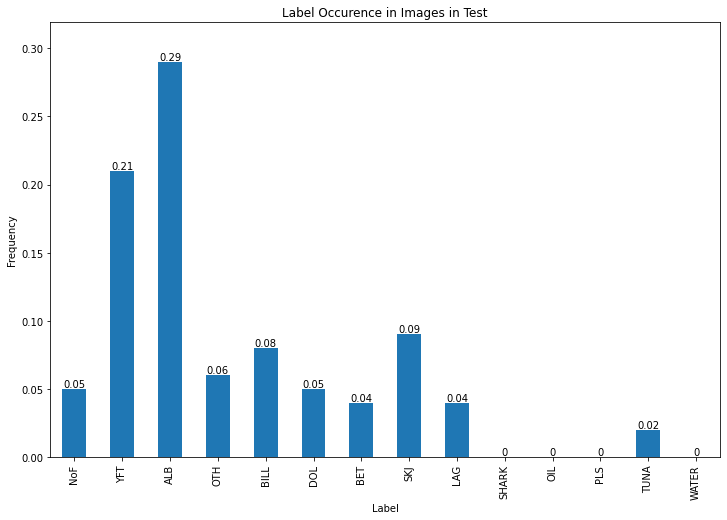

In [32]:
df_counts = pd.DataFrame({'Frequency': frequency}, index=y_labels)
ax = df_counts.plot(kind='bar', figsize=(12, 8), title='Label Occurence in Images in Test',
             xlabel='Label', ylabel='Frequency', legend=False)

# annotate
ax.bar_label(ax.containers[0], label_type='edge')

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

In the test data the occurences become even sparser. Most categories occur less than 10% of the time, and many categories appear less than 5% of the time.

In [33]:
print(len(y_labels))
counts = []
for i in range(0,14):
    x = list(Y_preds.groupby(i).size())
    counts.append(x[0]/100)
print(counts)
print(len(counts))
frequency= [round(1-i, 3) for i in counts]
print(frequency)
print(len(frequency))

14
[0.98, 0.97, 0.97, 1.0, 1.0, 1.0, 1.0, 0.99, 0.99, 1.0, 1.0, 1.0, 0.98, 1.0]
14
[0.02, 0.03, 0.03, 0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.0, 0.0, 0.0, 0.02, 0.0]
14


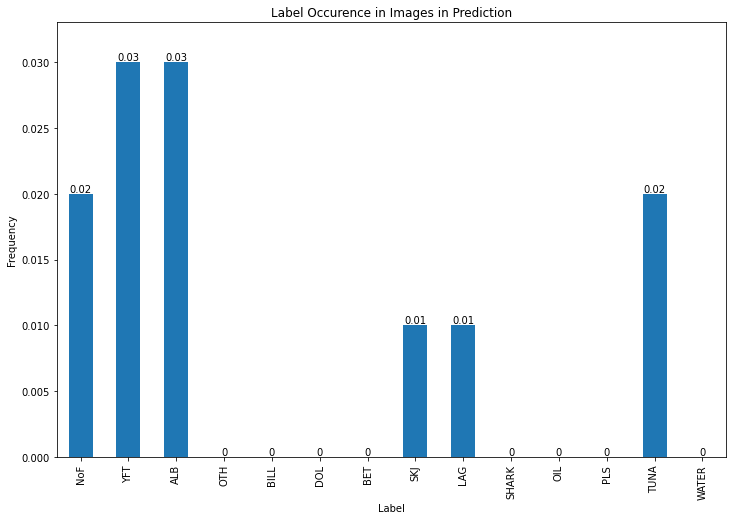

In [34]:
df_counts = pd.DataFrame({'Frequency': frequency}, index=y_labels)
ax = df_counts.plot(kind='bar', figsize=(12, 8), title='Label Occurence in Images in Prediction',
             xlabel='Label', ylabel='Frequency', legend=False)

# annotate
ax.bar_label(ax.containers[0], label_type='edge')

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

The predictions lack of accuracy is highly apparent in the frequency plot, which ideally would be identically to the test plot.

In [35]:
from sklearn.metrics import coverage_error

In [36]:
print(coverage_error(y_test, y_pred))

10.79


Here we look at further metrics to determine how in accurate the model is. A 'good' coverage error would be closer to the number of categories. 

In [37]:
exact_acc = (y_test == y_pred).all(axis=1).mean()

In [38]:
print("Exact Match Ratio:", exact_acc)

Exact Match Ratio: 0.2


The exact match ratio is the number of rows that much perfectly. The ratio is 22%, which is not great but shows that one fifth of all the images were classified 100% correctly.

## Previous Solutions

In order to raise the accuracy without overfitting there were a variety of different solutions proposed. The first attempt was to create my own model without transfer modeling. The model predicted that every image had a YFT and a Human (a serious issue of overfitting returning a 98% accuracy). The next step was to use freezing layers, which also caused overfitting returning that each image had nothing in it. In addition to freezing layers, different learning rates were also tried, which once again brought the no categories present over fitting issue. The large issue with other solutions were overfitting, which predicted patterns based on the sparesenss of the dataset rather than what actually was in the image.

### Samples of Old Code

#### Old Model
*      model = Sequential()
*      model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(400,400,3)))
*      model.add(MaxPooling2D(pool_size=(2, 2)))
*      model.add(Dropout(0.25))
*      model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))   
*      model.add(MaxPooling2D(pool_size=(2, 2)))
*      model.add(Dropout(0.25))
*      model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
*      model.add(MaxPooling2D(pool_size=(2, 2)))
*      model.add(Dropout(0.25))
*      model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
*      model.add(MaxPooling2D(pool_size=(2, 2)))
*      model.add(Dropout(0.25))
*      model.add(Flatten())
*      model.add(Dense(128, activation='relu'))
*      model.add(Dropout(0.5))
*      model.add(Dense(64, activation='relu'))
*      model.add(Dropout(0.5))
*      model.add(Dense(15, activation='sigmoid'))
*      from keras.utils.vis_utils import plot_model


* for layer in model2.layers[:172]:
*        > layer.trainable = False
* for layer in model2.layers[172:]:
*       > layer.trainable = True
* model.summary()
* plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
* es = EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy') # Early stopping
* initial_learning_rate = 0.01
* epochs = 50
* decay = initial_learning_rate / epochs
* def lr_time_based_decay(epoch, lr):
*     > return lr # 1 / (1 + decay # epoch)

## Discussion and Results

Fish identification is a difficult task. Fish depending on their age can have different fin structures, coloring, and can have radically different sizes. On top of this even trained marine biologists can not differentiate fish tuna species from each other without examining the fish's liver (i.e. yellowfin tuna and bigeye tuna). Using image labelling technology is not a silver bullet solution due to the variability in fish species. The proposed model's accuracy is a strong indicator about some of the challenges of image recognition and deep learning. One of the first questions the model raises is: Is image recognition right for this project? Arguably no, but image recognition can be used as a broad indicator to see catch number for maybe not fish species but maybe genus. A possible new project would be to differentiate between billfish (sowrdfish, marlin, spearfish) and tunas (bluefin Tuna, albacore, skipjack tuna). Another issue is the distribution of how often the classes appear. Most of the classes appear rarely in an image, which makes it difficult to train the model because an accurate model can predict an image saying that it has none of the classes in it and still be fairly accurate a significant portion of the time. By having broader categories (i.e. by selecting by genus), the occurence issue would be partially alleviated. In addition, we could weight the images so that there is more diversity in the training set, so the model can train more effectively. Using image recognition and multilabelling does have merit to further protect the environment and our fisheries and would be best served with more research. Due to the limitations of resources (RAM limitations for one) and data this project faced major challeneges. With more research and a rexamining of what the goal of our project is, a more accurate and helpful model is possible. However, this model serves as an indicator about the hardships of multilabelling, and serves as useful reminder that deep learning is not necessarily a silver bullet solution.